In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import time
from collections import defaultdict as ddict

# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

In [2]:
# bring in dataframe from csv file created at the end of Project_1_data_cleaning script
#using the combined stations and lines data to test theory. Combined = final_data.csv, uncombined = clean_data.csv

data = pd.read_csv('final_data.csv')

In [3]:
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Ent,Ext,day_of_week,month
0,A002,R051,02-00-00,59 STNQR456W,NQR456W,BMT,2018-02-24,07:00:00,REGULAR,6527794,2210507,14.0,11.0,Saturday,2
1,A002,R051,02-00-00,59 STNQR456W,NQR456W,BMT,2018-02-24,11:00:00,REGULAR,6527838,2210585,44.0,78.0,Saturday,2
2,A002,R051,02-00-00,59 STNQR456W,NQR456W,BMT,2018-02-24,15:00:00,REGULAR,6527994,2210644,156.0,59.0,Saturday,2
3,A002,R051,02-00-00,59 STNQR456W,NQR456W,BMT,2018-02-24,19:00:00,REGULAR,6528278,2210705,284.0,61.0,Saturday,2
4,A002,R051,02-00-00,59 STNQR456W,NQR456W,BMT,2018-02-24,23:00:00,REGULAR,6528389,2210728,111.0,23.0,Saturday,2


In [4]:
data['Traffic']=data['Ent']+data['Ext']

### MVP plots

In [5]:
#Converting the 8 pm to midnight data to the previous day.

data['TIME'] = pd.to_timedelta(data['TIME'], unit='h')

In [6]:
data.dtypes

C/A                     object
UNIT                    object
SCP                     object
STATION                 object
LINENAME                object
DIVISION                object
DATE                    object
TIME           timedelta64[ns]
DESC                    object
ENTRIES                  int64
EXITS                    int64
Ent                    float64
Ext                    float64
day_of_week             object
month                    int64
Traffic                float64
dtype: object

In [7]:
def subtractOneDay(day):
    if day == 'Saturday': new_day = 'Friday'
    elif day == 'Friday': new_day = 'Thursday'
    elif day == 'Thursday': new_day = 'Wednesday'
    elif day == 'Wednesday': new_day = 'Tuesday'
    elif day == 'Tuesday': new_day = 'Monday'
    elif day == 'Monday': new_day = 'Sunday'
    elif day == 'Sunday': new_day = 'Saturday'
    return new_day

In [8]:
data['new_day'] = data.day_of_week[data['TIME'] == '00:00:00'].apply(subtractOneDay)
data['new_day'] = data['new_day'].fillna(data['day_of_week'])

In [ ]:
#Converting times to categories during the day

In [32]:
def convertTimeToCategory(time):
    hour = time.hour
    if hour > 20 or hour == 0:
        category = 'Night'
    elif hour > 16:
        category = 'Evening'
    elif hour > 12:
        category = 'Afternoon'
    elif hour > 8:
        category = 'Morning'
    elif hour > 4:
        category = 'Early Risers'
    elif hour > 0:
        category = 'Late Night'
    
    return category

In [33]:

data['TIME_2'] = pd.to_datetime(data['TIME']).dt.round('H')
data['Category'] = data['TIME_2'].apply(convertTimeToCategory)
data.drop(columns=['TIME_2'], inplace = True)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


##### By station

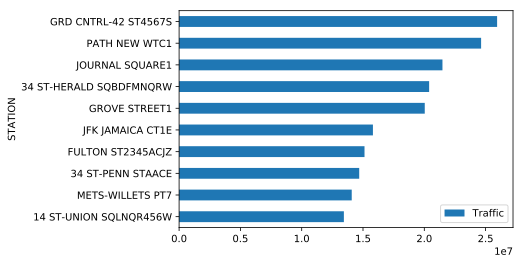

In [35]:
# compute total traffic (entries + exits, 'Traffic' column) per station for the entire data period and order from greatest to least
# set as new dataframe and limit to top 10
# plot as bar graph

by_station = data.groupby('STATION').sum().sort_values(by=['Traffic'], ascending=True)
traffic_by_station = pd.DataFrame(by_station)
by_station_top_ten = traffic_by_station.tail(10)
by_station_top_ten.plot.barh(y='Traffic');


##### By day of week

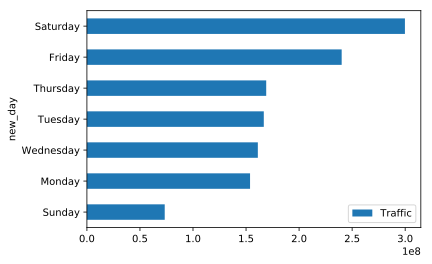

In [36]:
# compute total traffic per day of week for the entire data period and order from greatest to least
# set as new dataframe
# plot as bar graph

by_dow = data.groupby('new_day').sum().sort_values(by=['Traffic'], ascending = True)
by_dow = pd.DataFrame(by_dow)
by_dow.plot.barh(y='Traffic');

##### By time of day (delete this?)

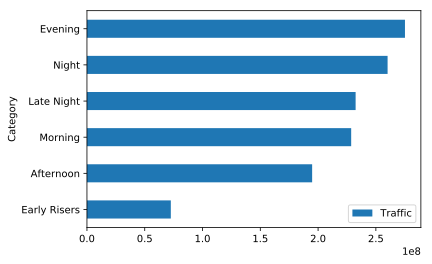

In [37]:
#by time of day (?)
# delete this? not very telling... 

by_time_of_day = data.groupby(['Category']).sum().sort_values(by=['Traffic'], ascending = True)
by_time_of_day = pd.DataFrame(by_time_of_day)
by_time_of_day.plot.barh(y='Traffic');

### Figuring out weekly schedule

In [1]:
# weekly schedule (from Natasha) (?)


#data.groupby('STATION').sum().sort_values(by=['Traffic'],ascending=False)

#weekly_schedule = (data.groupby(['new_day','STATION']).sum().reset_index())

#weekly_all = pd.DataFrame(weekly_schedule)

#by_day = weekly_all.set_index('new_day')

##### Time series analysis attempt

In [114]:
by_day.head(5)

,STATION,ENTRIES,EXITS,Ent,Ext,month,sum_ent_ext
day_of_week,,,,,,,
Friday,1 AVL,291510739454,155944064137,372228.0,405586.0,4140,777814.0
Friday,103 ST-CORONA7,6321261317,6538568570,321039.0,226472.0,3806,547511.0
Friday,103 ST1,5736379954,3115262489,210825.0,101658.0,2484,312483.0
Friday,103 ST6,6018185835,51905557760,217409.0,189965.0,2484,407374.0
Friday,103 STBC,3297255497,2878873548,98732.0,59864.0,1557,158596.0


In [ ]:
# Create a time series plot of traffic each day of the week
# x-axis = day of the week (Monday through Sunday)
# y-axis = SUM() or MEDIAN() of traffic
# each line represents one of the top 10 stations



In [113]:
# sort by station, unit, scp, and date in order to organize dates in chronological order per station

by_station = data.sort_values(by = ['STATION', 'UNIT', 'SCP', 'DATE'])
# by_station = clean_merge.groupby('STATION').sum().sort_values(by=['sum_ent_ext'], ascending=True)
by_station.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,month,day_of_week,Ent,Ext,Traffic,Category
28630,H007,R248,00-00-00,1 AV,L,BMT,2018-02-24,11:00:00,REGULAR,13248469,14794864,2,Saturday,369.0,694.0,1063.0,Morning
28631,H007,R248,00-00-00,1 AV,L,BMT,2018-02-24,15:00:00,REGULAR,13249209,14795967,2,Saturday,740.0,1103.0,1843.0,Afternoon
28632,H007,R248,00-00-00,1 AV,L,BMT,2018-02-24,19:00:00,REGULAR,13250036,14797030,2,Saturday,827.0,1063.0,1890.0,Evening
28633,H007,R248,00-00-00,1 AV,L,BMT,2018-02-24,23:00:00,REGULAR,13250668,14797982,2,Saturday,632.0,952.0,1584.0,Night
28634,H007,R248,00-00-00,1 AV,L,BMT,2018-02-25,03:00:00,REGULAR,13250867,14798420,2,Sunday,199.0,438.0,637.0,Late Night


In [112]:
# create Journal Square station data_frame
#df_journal_square = data[data['STATION'] == 'JOURNAL SQUARE1']
#df_journal_square

# isolate time window at Journal Square (in attempt to do time series analysis)
#df_journal_square_time_window = df_journal_square[(df_journal_square['DATE'] >= '2018-03-05') & (df_journal_square['DATE'] <= '2018-03-11')]
#df_journal_square_time_window_sorted = df_journal_square_time_window.sort_values(by=['SCP','DATE'])
#df_journal_square_time_window_sorted.head(50)

# sort by station, unit, scp, and date so we have an ordered time series
# df_journal_square.sort_values(by = ['STATION', 'UNIT', 'SCP', 'DATE'])
# No need to sort by, right?

# check how many units there are in Journal Square (to see if we can make a time series analysis without aggregating units)
# df_journal_square['UNIT'].nunique()

# NEXT UP: Create a Journal Square time series (on an hourly time scale) within a set period of dates

In [111]:
# create WTC station data_frame
#df_wtc = data[data['STATION'] == 'PATH NEW WTC']
#df_wtc

### Analysis for individual stations

In [32]:
# Penn Station

#penn = data[data['STATION']=='34 ST-PENN STA'].groupby(['day_of_week']).sum()
#penn

In [57]:
# rename sum_ent_ext column to traffic -- move to data cleaning file!

#data.rename(index=str, columns={"sum_ent_ext": "Traffic"}, inplace = True)

In [39]:
by_station_top_ten = traffic_by_station.tail(10)
by_station_top_ten

,ENTRIES,EXITS,Ent,Ext,month,Traffic
STATION,,,,,,
14 ST-UNION SQLNQR456W,294948912299,132508145547,7135662.0,6304710.0,71101,13440372.0
METS-WILLETS PT7,31933154352,7923944183,11273350.0,2807691.0,99120,14081041.0
34 ST-PENN STAACE,1096952091980,1048865905736,7728707.0,6962085.0,153823,14690792.0
FULTON ST2345ACJZ,736821925301,1429696261806,8597398.0,6526211.0,172874,15123609.0
JFK JAMAICA CT1E,1363610250,1129955762,9183332.0,6626681.0,28627,15810013.0
GROVE STREET1,3876598306,4122607058,13382601.0,6655126.0,51494,20037727.0
34 ST-HERALD SQBDFMNQRW,1107344747017,1006980756116,10590430.0,9803910.0,140150,20394340.0
JOURNAL SQUARE1,5631565392,4816668999,15445494.0,6035905.0,56842,21481399.0
PATH NEW WTC1,4103133083,4177606217,11168544.0,13465291.0,117576,24633835.0


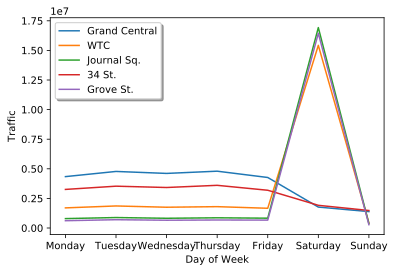

In [40]:
# line chart of total traffic per day for top stations

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

by_station = data.groupby(['STATION', 'new_day']).sum()
penn = by_station.loc['GRD CNTRL-42 ST4567S'].reindex(ordered_days)
gct = by_station.loc['PATH NEW WTC1'].reindex(ordered_days)
wtc = by_station.loc['JOURNAL SQUARE1'].reindex(ordered_days)
tsq = by_station.loc['34 ST-HERALD SQBDFMNQRW'].reindex(ordered_days)
jsq = by_station.loc['GROVE STREET1'].reindex(ordered_days)
fulton = by_station.loc['JFK JAMAICA CT1E'].reindex(ordered_days)
herald = by_station.loc['FULTON ST2345ACJZ'].reindex(ordered_days)
grove = by_station.loc['34 ST-PENN STAACE'].reindex(ordered_days)
union = by_station.loc['METS-WILLETS PT7'].reindex(ordered_days)
canal = by_station.loc['14 ST-UNION SQLNQR456W'].reindex(ordered_days)

# penn.plot(y='Traffic')
# gct.plot(y='Traffic')

plt.plot(penn.loc[:, 'Traffic'])
plt.plot(gct.loc[:, 'Traffic'])
plt.plot(wtc.loc[:, 'Traffic'])
plt.plot(tsq.loc[:, 'Traffic'])
plt.plot(jsq.loc[:, 'Traffic'])
# plt.plot(fulton.loc[:, 'Traffic'])
# plt.plot(herald.loc[:, 'Traffic'])
# plt.plot(grove.loc[:, 'Traffic'])
# plt.plot(union.loc[:, 'Traffic'])
# plt.plot(canal.loc[:, 'Traffic'])

plt.legend(['Grand Central','WTC','Journal Sq.','34 St.','Grove St.'],
           shadow = True, loc = 0);
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.show()

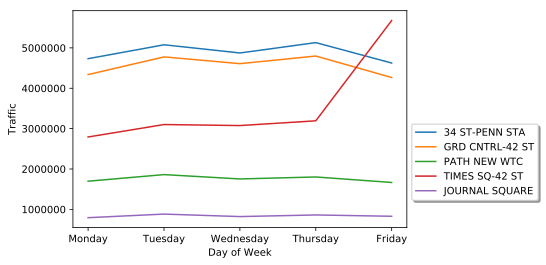

In [147]:
#Traffic Patterns during the week

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

by_station = data.groupby(['STATION', 'new_day']).sum()
penn = by_station.loc['34 ST-PENN STA'].reindex(ordered_days)
gct = by_station.loc['GRD CNTRL-42 ST'].reindex(ordered_days)
wtc = by_station.loc['PATH NEW WTC'].reindex(ordered_days)
tsq = by_station.loc['TIMES SQ-42 ST'].reindex(ordered_days)
jsq = by_station.loc['JOURNAL SQUARE'].reindex(ordered_days)
fulton = by_station.loc['FULTON ST'].reindex(ordered_days)
herald = by_station.loc['34 ST-HERALD SQ'].reindex(ordered_days)
grove = by_station.loc['GROVE STREET'].reindex(ordered_days)
union = by_station.loc['14 ST-UNION SQ'].reindex(ordered_days)
canal = by_station.loc['CANAL ST'].reindex(ordered_days)

# penn.plot(y='Traffic')
# gct.plot(y='Traffic')

plt.plot(penn.loc[:, 'Traffic'])
plt.plot(gct.loc[:, 'Traffic'])
plt.plot(wtc.loc[:, 'Traffic'])
plt.plot(tsq.loc[:, 'Traffic'])
plt.plot(jsq.loc[:, 'Traffic'])
# plt.plot(fulton.loc[:, 'Traffic'])
# plt.plot(herald.loc[:, 'Traffic'])
# plt.plot(grove.loc[:, 'Traffic'])
# plt.plot(union.loc[:, 'Traffic'])
# plt.plot(canal.loc[:, 'Traffic'])

plt.legend(['34 ST-PENN STA','GRD CNTRL-42 ST','PATH NEW WTC','TIMES SQ-42 ST','JOURNAL SQUARE'],
           shadow = True, loc = 0, bbox_to_anchor=(1.0, 0.5));
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.show()

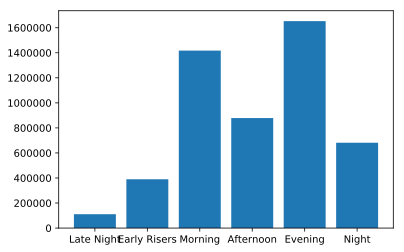

In [148]:
# Penn on Thursdays

ordered_times_1 = ['Late Night','Early Risers', 'Morning', 'Afternoon', 'Evening', 'Night']
# ordered_times_2 = ['03:00:00', '07:00:00', '11:00:00', '15:00:00', '19:00:00', '23:00:00']

gct = data.loc[data['STATION'] == '34 ST-PENN STA'].loc[data['new_day'] == 'Thursday']
gct1 = gct.groupby('Category').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_1)

# gct2 = gct.groupby('TIME').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_2)
plt.bar(ordered_times_1, gct1.loc[:, 'Traffic']);

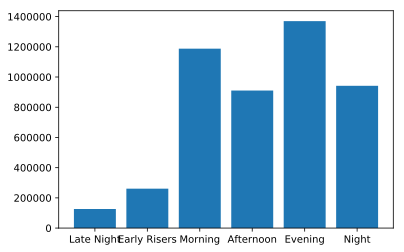

In [149]:
# Grand Central on Thursdays

ordered_times_1 = ['Late Night','Early Risers', 'Morning', 'Afternoon', 'Evening', 'Night']
# ordered_times_2 = ['03:00:00', '07:00:00', '11:00:00', '15:00:00', '19:00:00', '23:00:00']

gct = data.loc[data['STATION'] == 'GRD CNTRL-42 ST'].loc[data['new_day'] == 'Thursday']
gct1 = gct.groupby('Category').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_1)

# gct2 = gct.groupby('TIME').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_2)
plt.bar(ordered_times_1, gct1.loc[:, 'Traffic']);

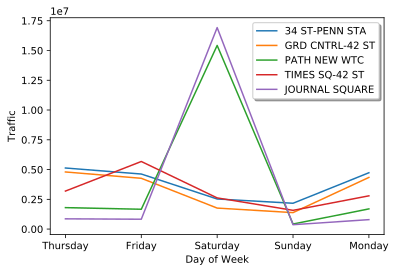

In [150]:
#Traffic Patterns during the weekend

ordered_days = ["Thursday","Friday", "Saturday", "Sunday", "Monday"]

by_station = data.groupby(['STATION', 'new_day']).sum()
penn = by_station.loc['34 ST-PENN STA'].reindex(ordered_days)
gct = by_station.loc['GRD CNTRL-42 ST'].reindex(ordered_days)
wtc = by_station.loc['PATH NEW WTC'].reindex(ordered_days)
tsq = by_station.loc['TIMES SQ-42 ST'].reindex(ordered_days)
jsq = by_station.loc['JOURNAL SQUARE'].reindex(ordered_days)
fulton = by_station.loc['FULTON ST'].reindex(ordered_days)
herald = by_station.loc['34 ST-HERALD SQ'].reindex(ordered_days)
grove = by_station.loc['GROVE STREET'].reindex(ordered_days)
union = by_station.loc['14 ST-UNION SQ'].reindex(ordered_days)
canal = by_station.loc['CANAL ST'].reindex(ordered_days)

# penn.plot(y='Traffic')
# gct.plot(y='Traffic')

plt.plot(penn.loc[:, 'Traffic'])
plt.plot(gct.loc[:, 'Traffic'])
plt.plot(wtc.loc[:, 'Traffic'])
plt.plot(tsq.loc[:, 'Traffic'])
plt.plot(jsq.loc[:, 'Traffic'])
# plt.plot(fulton.loc[:, 'Traffic'])
# plt.plot(herald.loc[:, 'Traffic'])
# plt.plot(grove.loc[:, 'Traffic'])
# plt.plot(union.loc[:, 'Traffic'])
# plt.plot(canal.loc[:, 'Traffic'])

plt.legend(['34 ST-PENN STA','GRD CNTRL-42 ST','PATH NEW WTC','TIMES SQ-42 ST','JOURNAL SQUARE'],
           shadow = True, loc = 0,);
plt.xlabel('Day of Week')
plt.ylabel('Traffic')
plt.show()

**Some comments for the above code:**
    
- For gct1 line of code -- you can remove ".sort_values(by = ['Traffic'], ascending = False)" from the line and the result will be the same (the same goes for any following code blocks with that line)
- By only using those "ordered_times", we are removing a lot of data, and therefore could be masking the true story. 

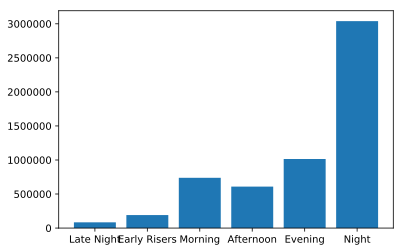

In [152]:
# Times Square on saturdays

tsq = data.loc[data['STATION'] == 'TIMES SQ-42 ST'].loc[data['new_day'] == 'Friday']
tsq = tsq.groupby('Category').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_1)
plt.bar(ordered_times_1, tsq.loc[:, 'Traffic']);

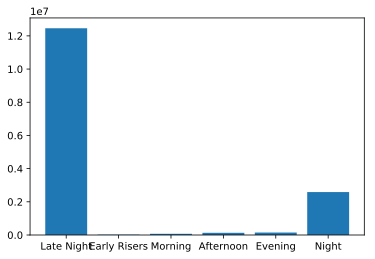

In [154]:
# Journal Square on saturdays

jsq = data.loc[data['STATION'] == 'PATH NEW WTC'].loc[data['new_day'] == 'Saturday']
jsq = jsq.groupby('Category').sum().sort_values(by = ['Traffic'], ascending = False).reindex(ordered_times_1)
plt.bar(ordered_times_1, jsq.loc[:, 'Traffic']);

In [155]:
jsq

,ENTRIES,EXITS,month,Ent,Ext,Traffic
Category,,,,,,
Late Night,14870458,22668331,666,4746464.0,7711850.0,12458314.0
Early Risers,100312699,98653879,2750,10674.0,10372.0,21046.0
Morning,99118724,101923275,2755,21013.0,53358.0,74371.0
Afternoon,101688360,104428214,2853,47128.0,87692.0,134820.0
Evening,98293573,97369674,2611,82441.0,65245.0,147686.0
Night,100385834,102144743,2789,1414668.0,1173229.0,2587897.0


In [79]:
# World Trade Center on Saturdays
# date time conversion still needs to be corrected due to 2019 date

#wtc = data.loc[data['STATION'] == 'PATH NEW WTC'].loc[data['day_of_week'] == 'Saturday']
# wtc['TIME'].dt.round('H')
#wtc['TIME2'] = pd.to_datetime(wtc['TIME'])
#wtc['TIME3'] = wtc['TIME2'].dt.round('H')
#wtc.head(20)
#wtc = wtc.groupby('TIME').sum().sort_values(by = ['Traffic'], ascending = False)
#wtc.head()
#plt.bar(ordered_times_1, wtc.loc[:, 'Traffic'])